In [ ]:
# Here we can connect google colab to google drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Here we can import all libraries as required:
import pandas as pd
import numpy as np
from numpy import array
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
%matplotlib inline

In [9]:
# Insert CSV file and print it:
df=pd.read_csv('/content/apple_share_price.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,11-Aug-17,156.60,158.57,156.07,157.48,26257096
1,10-Aug-17,159.90,160.00,154.63,155.32,40804273
2,9-Aug-17,159.26,161.27,159.11,161.06,26131530
3,8-Aug-17,158.60,161.83,158.27,160.08,36205896
4,7-Aug-17,157.06,158.92,156.67,158.81,21870321


***Data Visualization***

In [10]:
#EDA
df.shape

(1664, 6)

In [11]:
df1=df.reset_index()['Close'];df1

0       157.48
1       155.32
2       161.06
3       160.08
4       158.81
         ...  
1659     48.02
1660     47.68
1661     47.71
1662     47.33
1663     47.08
Name: Close, Length: 1664, dtype: float64

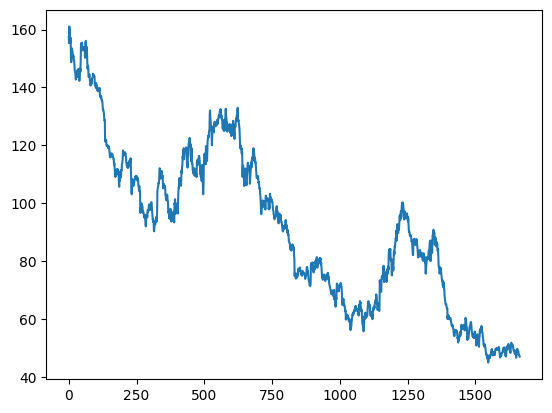

In [12]:
plt.plot(df1);plt.show()

In [13]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1));df1

array([[0.96914059],
       [0.95052151],
       [1.        ],
       ...,
       [0.02292906],
       [0.01965348],
       [0.01749849]])

In [14]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
print(training_size,test_size)

1081 583


In [15]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape), print(y_train.shape),print(X_test.shape), print(ytest.shape)

(980, 100)
(980,)
(482, 100)
(482,)


(None, None, None, None)

In [18]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
history=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

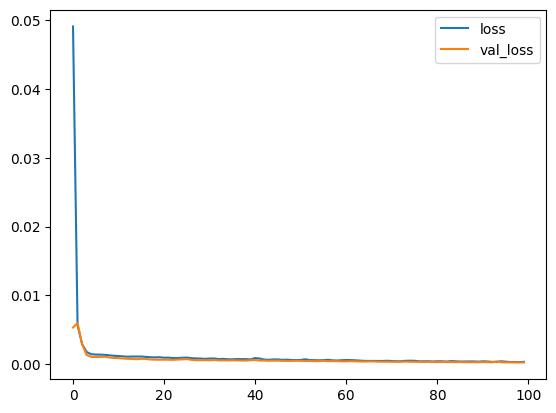

In [21]:
# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [22]:
train_predict=model.predict(X_train) #prediction
test_predict=model.predict(X_test)

16/16 [==============================] - 1s 31ms/step


In [23]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
#Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(ytest,test_predict)))

101.6113902710598
68.69290101553264


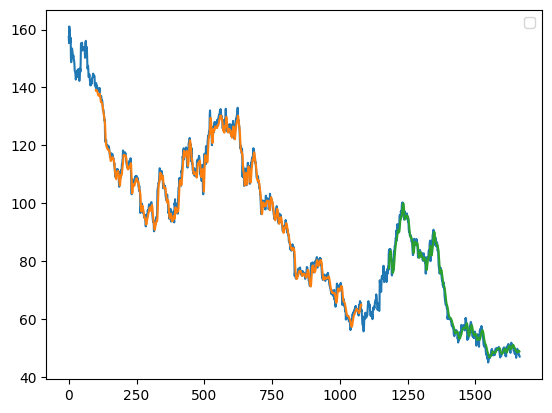

In [27]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

In [28]:
x_input=test_data[483:].reshape(1,-1) #len(test_data)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [29]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

# Output:
print(lst_output)

[0.02870895]
101
1 day input [0.02077407 0.02344625 0.02448065 0.03103181 0.03016981 0.02560124
 0.02206706 0.03094561 0.03844496 0.03922076 0.04197914 0.03973795
 0.03853116 0.03870356 0.04215154 0.04042755 0.03810016 0.04284113
 0.03870356 0.04284113 0.04318593 0.04637531 0.04353073 0.03335919
 0.02775623 0.02034307 0.01491251 0.02103267 0.02560124 0.02103267
 0.01905008 0.02430825 0.02801483 0.02792863 0.02896302 0.0318076
 0.03594518 0.04085855 0.04094475 0.04387553 0.04318593 0.04456512
 0.03646237 0.02939402 0.0318076  0.02948022 0.01887768 0.02379105
 0.01801569 0.03706577 0.04706491 0.04508232 0.03853116 0.04568572
 0.04973709 0.04930609 0.05499526 0.05447806 0.04525472 0.04180674
 0.04663391 0.04042755 0.03387639 0.03361779 0.02861822 0.04335833
 0.05292647 0.05887423 0.05482286 0.05396087 0.05111628 0.0482717
 0.05275407 0.0490475  0.04499612 0.03835876 0.03456599 0.03568658
 0.03654857 0.02948022 0.02551504 0.03430739 0.03508318 0.0320662
 0.02723903 0.01396431 0.02137747 0.

In [30]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

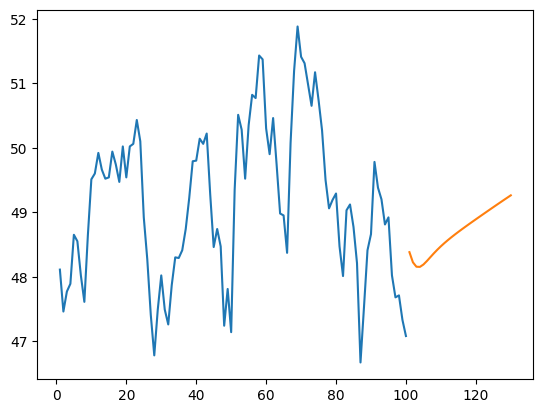

In [31]:
plt.plot(day_new,scaler.inverse_transform(df1[1564:])) #len(df1)
plt.plot(day_pred,scaler.inverse_transform(lst_output))

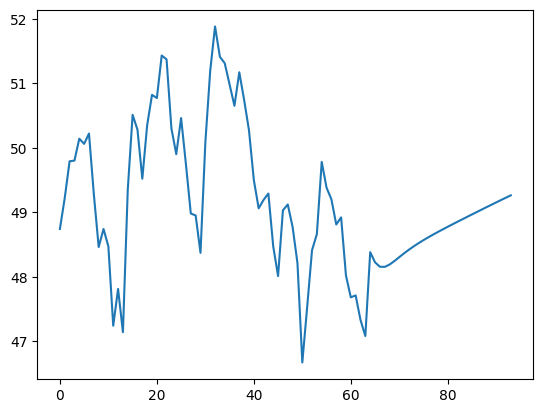

In [32]:
df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3[1600:])

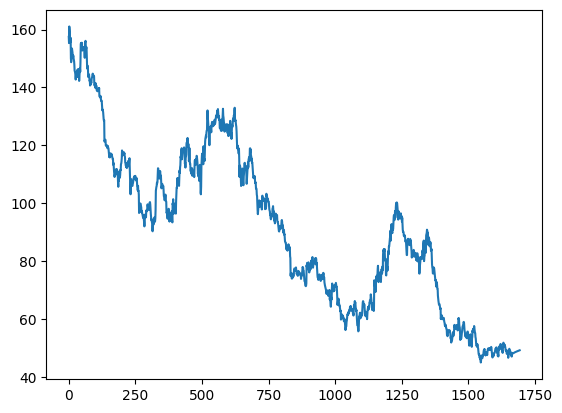

In [33]:
plt.plot(df3)